# ZKsync data exploration - Fees and gas

#### [Maria Silva](https://github.com/misilva73), June 2024

This notebook looks into gas usage and transaction fees for zksync over almost 1 year. We use two main sources of data - blocks and transaction receipts. This notebook should be an example of interacting and processing our [ZKsync public datasets](https://data.zksync.dev).

## Import packages

In [1]:
import os
import time
import polars as pl
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

Note that these are support functions defined in the `src` folder:

In [3]:
from plot_utils import get_plotly_layout, colors, update_plotly_layout_in_place

width, height = 800, 450

Sometimes, plotly takes some time to load Mathjax library, which messes with the pdf saves. This next cell is only here to save a garbage plot and guarantee that, for the actual final plots, the library is already loaded.

In [4]:
fig=px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.write_image("some_figure.pdf", format="pdf")
time.sleep(2)
os.remove("some_figure.pdf")

##  Load Polars DataFrames

Since the dataset is quite large, we are using polars to process the data. We first compute daily aggregates and then convert these smaller aggregated datasets into pandas DataFrames we can more easily use and plot.

In [5]:
# Set directory paths
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots", "gas_and_fees_example"))

# Set block limits
block_start = 56_1367 # starting on April 1st to ignore weird blocks during era launch
block_end = 29_710_983

In [6]:
# Load blocks data
blocks_path = os.path.join(data_dir, "blocks", "blocks_*.parquet")
blocks_lazy_df = (
    pl.scan_parquet(blocks_path)
    .filter(pl.col("number").is_between(block_start, block_end))
    .with_columns(pl.from_epoch("timestamp", time_unit="s"))
    .with_columns(pl.col("timestamp").cast(pl.Date).alias("day"))
    .sort("timestamp")
)
blocks_lazy_df.schema

OrderedDict([('hash', String),
             ('parentHash', String),
             ('sha3Uncles', String),
             ('miner', String),
             ('stateRoot', String),
             ('transactionsRoot', String),
             ('receiptsRoot', String),
             ('number', Int64),
             ('l1BatchNumber', String),
             ('gasUsed', Int64),
             ('gasLimit', Int64),
             ('baseFeePerGas', Int64),
             ('extraData', String),
             ('logsBloom', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('l1BatchTimestamp', String),
             ('difficulty', Int64),
             ('totalDifficulty', Int64),
             ('sealFields', List(Null)),
             ('uncles', List(Null)),
             ('size', Int64),
             ('mixHash', String),
             ('nonce', String),
             ('day', Date)])

In [7]:
# Create temp df to join timestamps and date
temp_blocks_df = (
    blocks_lazy_df.select(pl.col("number"), pl.col("timestamp"), pl.col("day"))
)

# Load transaction data
txs_path = os.path.join(data_dir, "tx_receipts", "tx_receipts_*.parquet")
txs_lazy_df = (
    pl.scan_parquet(txs_path)
    .filter(pl.col("blockNumber").is_between(block_start, block_end))
    .join(temp_blocks_df, left_on="blockNumber", right_on="number")
    .sort("timestamp")
)
txs_lazy_df.schema

OrderedDict([('blockHash', String),
             ('blockNumber', Int64),
             ('contractAddress', String),
             ('cumulativeGasUsed', Int64),
             ('effectiveGasPrice', Int64),
             ('from', String),
             ('gasUsed', Int64),
             ('l1BatchNumber', String),
             ('l1BatchTxIndex', String),
             ('logsBloom', String),
             ('root', String),
             ('status', Int64),
             ('to', String),
             ('transactionHash', String),
             ('transactionIndex', Int64),
             ('type', Int64),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('day', Date)])

##  Process Polars DataFrames

This is the step where we compute the aggregates and convert to pandas.

In [8]:
# Compute daily aggregated data for blocks
block_data_per_day_df = (
    blocks_lazy_df
    .group_by("day")
    .agg(
        pl.col("gasUsed").mean().alias("avg_gas_used_block"),
        pl.col("gasUsed").sum().alias("total_gas_used_day"),
        pl.col("gasLimit").sum().alias("total_gas_limit_day"),
        (pl.col("gasUsed").sum()/pl.col("gasLimit").sum()).alias("gas_utilization_rate_day"),
        pl.col("baseFeePerGas").mean().alias("avg_base_fee_price_block")
    )
    .sort("day")
    .collect(streaming=True)
    .to_pandas()
)
block_data_per_day_df.head()

,day,avg_gas_used_block,total_gas_used_day,total_gas_limit_day,gas_utilization_rate_day,avg_base_fee_price_block
0,2023-04-01,5.113545e+06,291185722800,244572617646480,0.001191,250000000.0
1,2023-04-02,4.577601e+06,315039633258,295588239176490,0.001066,250000000.0
2,2023-04-03,5.901565e+06,413428260014,300879638883930,0.001374,250000000.0
3,2023-04-04,5.624768e+06,387569003304,295940426494680,0.001310,250000000.0
4,2023-04-05,6.048327e+06,422415145071,299960515882800,0.001408,250000000.0


In [9]:
# Compute daily aggregated data for transactions

tx_data_per_day_df = (
    txs_lazy_df
    .group_by("day")
    .agg(
        pl.col("gasUsed").mean().alias("avg_gas_used_tx"),
        pl.col("gasUsed").sum().alias("total_gas_used_day"),
        pl.col("effectiveGasPrice").mean().alias("avg_gas_price_tx"),
        pl.col("transactionHash").count().alias("tx_count")
    )
    .sort("day")
    .collect(streaming=True)
    .to_pandas()
)
tx_data_per_day_df["avg_gas_price_tx_gwei"] = tx_data_per_day_df["avg_gas_price_tx"]*0.000000001
tx_data_per_day_df["Month"] = tx_data_per_day_df["day"].dt.month_name() + " " + tx_data_per_day_df["day"].dt.year.astype("str")
tx_data_per_day_df.head()

,day,avg_gas_used_tx,total_gas_used_day,avg_gas_price_tx,tx_count,avg_gas_price_tx_gwei,Month
0,2023-04-01,8.389198e+05,291185722800,2.720168e+08,347096,0.272017,April 2023
1,2023-04-02,7.853745e+05,315039633258,2.700304e+08,401133,0.270030,April 2023
2,2023-04-03,9.921389e+05,413428260014,2.667310e+08,416704,0.266731,April 2023
3,2023-04-04,1.051308e+06,387569003304,2.670195e+08,368654,0.267020,April 2023
4,2023-04-05,1.376129e+06,422415145071,2.668927e+08,306959,0.266893,April 2023


## Daily transactions

We are stating with a daily count of transactions:

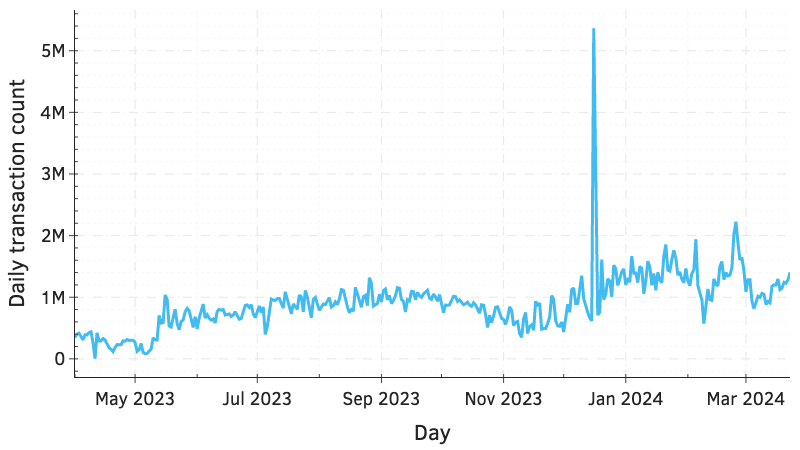

In [10]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df['day'][:-1], 
    y=tx_data_per_day_df['tx_count'][:-1], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Daily transaction count",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'total-tx-day.pdf'))
fig.show('png')

In [11]:
tx_data_per_day_df['tx_count'][:-1].agg(["mean", "std", "median"])

mean      905193.706704
std       452633.662131
median    886551.000000
Name: tx_count, dtype: float64

In [12]:
tx_data_per_day_df['tx_count'][:-1].max()

np.uint32(5362921)

In [13]:
tx_data_per_day_df['tx_count'][:-1].min()

np.uint32(3566)

## Gas usage analysis

Now, let's look at gas usage!

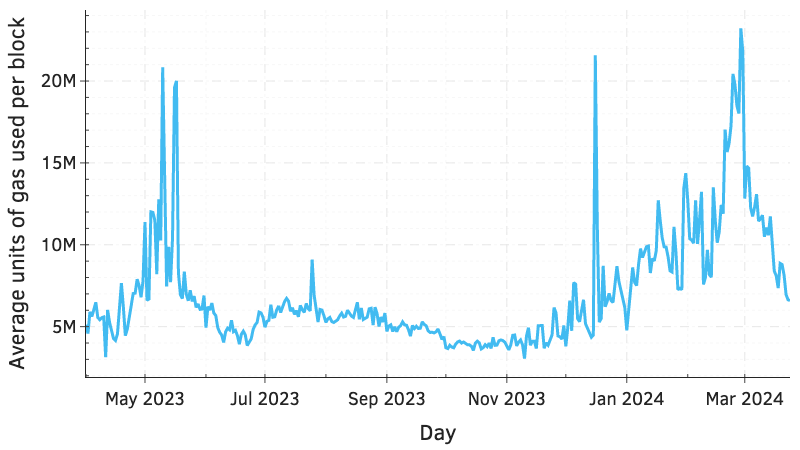

In [14]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df['day'], 
    y=block_data_per_day_df['avg_gas_used_block'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Average units of gas used per block",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-gas-used-block.pdf'))
fig.show('png')

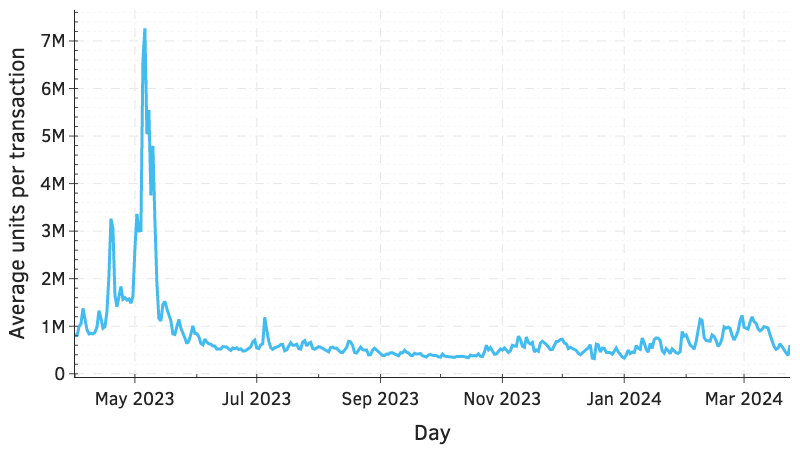

In [15]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df['day'], 
    y=tx_data_per_day_df['avg_gas_used_tx'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Average units per transaction",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-gas-used-tx.pdf'))
fig.show('png')

In [16]:
tx_data_per_day_df['avg_gas_used_tx'].mean()

np.float64(784149.1092310325)

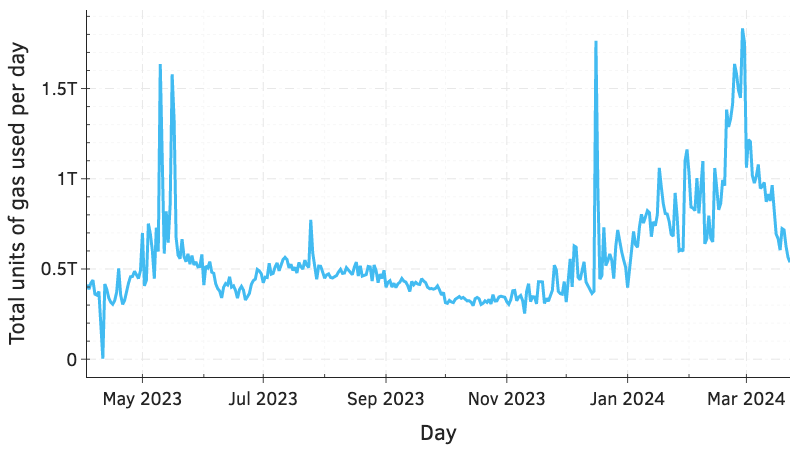

In [17]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df.iloc[2:-1]['day'], 
    y=block_data_per_day_df.iloc[2:-1]['total_gas_used_day'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day",
                  yaxis_title="Total units of gas used per day", 
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'daily-total-gas-used.pdf'))
fig.show('png')

In [18]:
block_data_per_day_df.iloc[2:-1]['total_gas_used_day'].agg(["mean", "std", "median", "max", "min"])

mean      5.671120e+11
std       2.804711e+11
median    4.766464e+11
max       1.833569e+12
min       3.110912e+09
Name: total_gas_used_day, dtype: float64

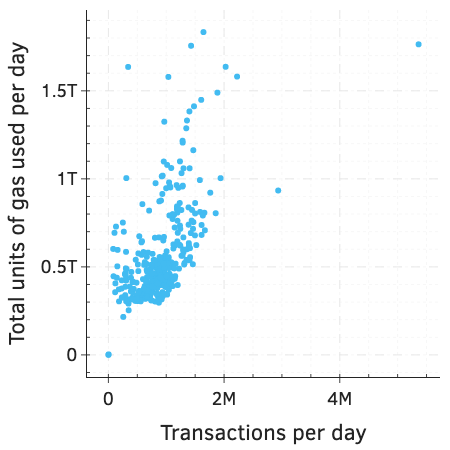

In [19]:
fig = go.Figure(layout=get_plotly_layout(width=height, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df['tx_count'], 
    y=tx_data_per_day_df['total_gas_used_day'], 
    line=dict(color=colors['blue'], width=3), mode='markers'))

fig.update_layout(xaxis_title="Transactions per day", 
                  yaxis_title="Total units of gas used per day",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'total-gas-used-vs-tx-count.pdf'))
fig.show('png')

## Gas usage spikes in detail

Let's now big into how we are seeing those gas spikes in May 2023 and March 2024. We know that the spike in December 2023 was due to the [inscriptions boom](https://arxiv.org/pdf/2405.15288).

In [20]:
may_2023_to_gas_df = (
    txs_lazy_df
    .filter(pl.col('day').is_between(datetime(2023, 5, 1), datetime(2023, 5, 30)))
    .group_by("to")
    .agg(
        pl.col("gasUsed").sum().alias("total_gas_used"),
        pl.col("transactionHash").count().alias("tx_count")
    )
    .collect(streaming=True)
    .to_pandas()
    .sort_values("total_gas_used", ascending=False)
)
may_2023_to_gas_df["perc_gas_used"] = may_2023_to_gas_df["total_gas_used"]/may_2023_to_gas_df["total_gas_used"].sum()
may_2023_to_gas_df.head(10)

,to,total_gas_used,tx_count,perc_gas_used
1111132,0x2da10A1e27bF85cEdD8FFb1AbBe97e53391C0295,4342713437988,2487896,0.205157
442456,0x9aA48260Dc222Ca19bdD1E964857f6a2015f4078,2365297526867,984481,0.111740
409999,0x3355df6D4c9C3035724Fd0e3914dE96A5a83aaf4,856000155392,1336346,0.040439
686468,0x8B791913eB07C32779a16750e3868aA8495F5964,845323176495,414179,0.039934
693808,0x9606eC131EeC0F84c95D82c9a63959F2331cF2aC,788411404467,436847,0.037246
687311,0xA0924Cc8792836F48D94759c76D32986BC74B54c,780212750665,693633,0.036858
692535,0x112E5059a4742ad8b2baF9C453fDA8695c200454,603769339804,216883,0.028523
1163645,0x47EF4A5641992A72CFd57b9406c9D9cefEE8e0C4,556649660597,596654,0.026297
170679,0xbE7D1FD1f6748bbDefC4fbaCafBb11C6Fc506d1d,474447896165,347049,0.022414
230057,0x5AEa5775959fBC2557Cc8789bC1bf90A239D9a91,458271916888,850604,0.021649


In [21]:
may_2023_from_gas_df = (
    txs_lazy_df
    .filter(pl.col('day').is_between(datetime(2023, 5, 1), datetime(2023, 5, 30),))
    .group_by("from")
    .agg(
        pl.col("gasUsed").sum().alias("total_gas_used"),
        pl.col("transactionHash").count().alias("tx_count")
    )
    .collect(streaming=True)
    .to_pandas()
    .sort_values("total_gas_used", ascending=False)
)
may_2023_from_gas_df["perc_gas_used"] = may_2023_from_gas_df["total_gas_used"]/may_2023_from_gas_df["total_gas_used"].sum()
may_2023_from_gas_df.head(10)

,from,total_gas_used,tx_count,perc_gas_used
770063,0x80C67432656d59144cEFf962E8fAF8926599bCF8,180157305241,210588,0.008511
1426988,0xE4eDb277e41dc89aB076a1F049f4a3EfA700bCE8,159081794333,184172,0.007515
986876,0xe19105463D6FE2f2BD86c69Ad478F4B76Ce49c53,104880453015,21810,0.004955
523801,0x888270Ff52f486729eF865466340D4eaC83a31D6,76953395041,106726,0.003635
918951,0x685Ee51518320A6625fA2BB523b2eAb385df68b3,74090716959,13898,0.003500
1368464,0xd99ac0681b904991169a4f398B9043781ADbe0C3,59267466934,31175,0.002800
17008,0x2Fc617E933a52713247CE25730f6695920B3befe,43182786356,58097,0.002040
290071,0x0D0707963952f2fBA59dD06f2b425ace40b492Fe,43044976339,12610,0.002034
779653,0x66E08198b5366Fc0CDe5fD78CC7B7686e554586f,37592718621,14213,0.001776
276817,0x309Af72B0952EB4E6F080D93f182BAf6fcC725A3,33427779571,13954,0.001579


In [22]:
mar_2024_to_gas_df = (
    txs_lazy_df
    .filter(pl.col('day').is_between(datetime(2024, 2, 15), datetime(2024, 3, 15)))
    .group_by("to")
    .agg(
        pl.col("gasUsed").sum().alias("total_gas_used"),
        pl.col("transactionHash").count().alias("tx_count")
    )
    .collect(streaming=True)
    .to_pandas()
    .sort_values("total_gas_used", ascending=False)
)
mar_2024_to_gas_df["perc_gas_used"] = mar_2024_to_gas_df["total_gas_used"]/mar_2024_to_gas_df["total_gas_used"].sum()
mar_2024_to_gas_df.head(10)

,to,total_gas_used,tx_count,perc_gas_used
166419,0x9b5def958d0f3b6955cbea4d5b7809b2fb26b059,3040304432076,3672959,0.087684
290132,0x3355df6d4c9c3035724fd0e3914de96a5a83aaf4,1797229621658,3127344,0.051833
1525671,0x5155704bb41fde152ad3e1ae402e8e8b9ba335d3,1125569763772,2508114,0.032462
989248,0x8b791913eb07c32779a16750e3868aa8495f5964,1116358798509,1222912,0.032196
1514290,0x4bba932e9792a2b917d47830c93a9bc79320e4f7,989424998031,1090769,0.028535
1700891,0x39e098a153ad69834a9dac32f0fca92066ad03f4,957580677357,944343,0.027617
188970,0x18381c0f738146fb694de18d1106bde2be040fa4,754934954808,905985,0.021773
761611,0x8cc9502fd26222ab38a25eee76ae4c7493a3fa2a,733802187124,328711,0.021163
117412,0x1a640bf545e04416df6ffa2f9cc4813003e52649,703400839285,188091,0.020286
127143,0x2da10a1e27bf85cedd8ffb1abbe97e53391c0295,699301215889,1036796,0.020168


In [23]:
mar_2024_from_gas_df = (
    txs_lazy_df
    .filter(pl.col('day').is_between(datetime(2024, 2, 15), datetime(2024, 3, 15)))
    .group_by("from")
    .agg(
        pl.col("gasUsed").sum().alias("total_gas_used"),
        pl.col("transactionHash").count().alias("tx_count")
    )
    .collect(streaming=True)
    .to_pandas()
    .sort_values("total_gas_used", ascending=False)
)
mar_2024_from_gas_df["perc_gas_used"] = mar_2024_from_gas_df["total_gas_used"]/mar_2024_from_gas_df["total_gas_used"].sum()
mar_2024_from_gas_df.head(10)

,from,total_gas_used,tx_count,perc_gas_used
974810,0x05411bcc63167a82057be42bc1b7022c12c99aa4,250729142167,837119,0.007231
923805,0xcb4dc6d8386ef8a52a5e02bcfa8c7faf889393b7,175760788116,35704,0.005069
511905,0xe5601264e9e00b7509fdf565102e042bedff254c,160479840174,34800,0.004628
108018,0x000006c733b6ed5f519da818f2444febf82167bd,75141750785,87965,0.002167
830375,0x7aed074ca56f5050d5a2e512ecc5bf7103937d76,63922571284,186647,0.001844
3149200,0xa92e09e0a52b7edead75d3125e21bdfb9752c69e,62310112047,10929,0.001797
644539,0xafab3d2c0283bf088a5c8abec6416bd72798256f,57572944473,31442,0.001660
1312268,0xa84fd90d8640fa63d194601e0b2d1c9094297083,48343767243,138198,0.001394
2198864,0x80c67432656d59144ceff962e8faf8926599bcf8,45733097802,163871,0.001319
1262112,0x9444eb5cd71eea640762aec49247ed50c768b397,44151902892,57486,0.001273


## Gas fees analysis

And, finally, we can look into transaction fees.

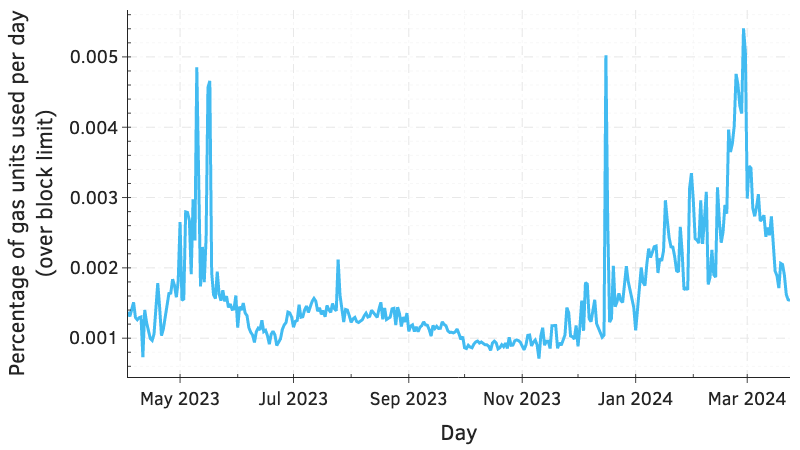

In [24]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df.iloc[2:]['day'], 
    y=block_data_per_day_df.iloc[2:]['gas_utilization_rate_day'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Percentage of gas units used per day<br>(over block limit)",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'gas-utilization-rate-day.pdf'))
fig.show('png')

In [25]:
block_data_per_day_df.iloc[2:]['gas_utilization_rate_day'].mean()

np.float64(0.0016359680152909332)

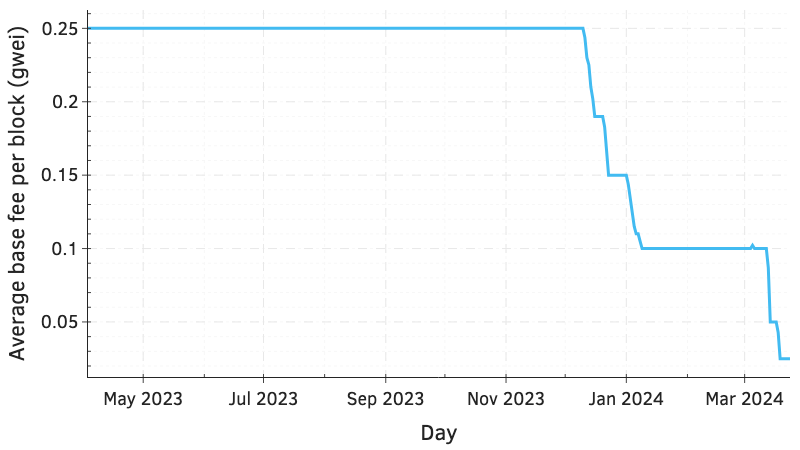

In [26]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=block_data_per_day_df.iloc[2:]['day'], 
    y=block_data_per_day_df.iloc[2:]['avg_base_fee_price_block']*0.000000001, 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day",
                  yaxis_title="Average base fee per block (gwei)",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-base-fee-price-day.pdf'))
fig.show('png')

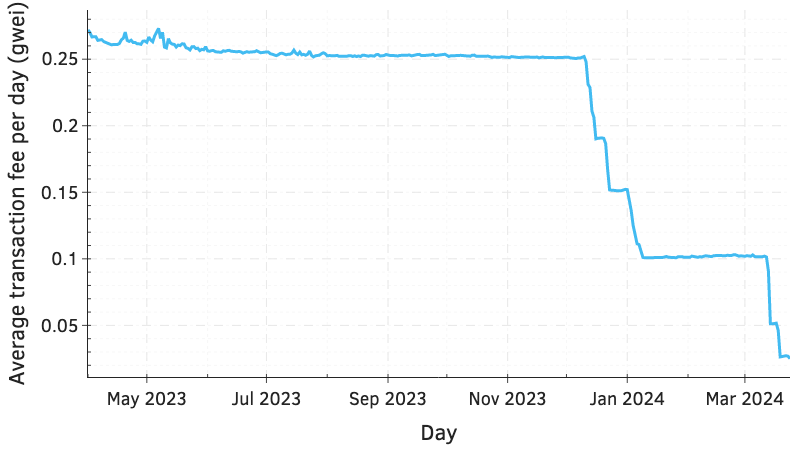

In [27]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=tx_data_per_day_df['day'], 
    y=tx_data_per_day_df['avg_gas_price_tx_gwei'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", 
                  yaxis_title="Average transaction fee per day (gwei)",
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

fig.write_image(os.path.join(plots_dir,'avg-tx-fee-day.pdf'))
fig.show('png')

In [28]:
tx_data_per_day_df[tx_data_per_day_df["day"].dt.year == 2023]["avg_gas_price_tx_gwei"].mean()

np.float64(0.24967777005238267)

In [29]:
tx_data_per_day_df["avg_gas_price_tx_gwei"].min()

np.float64(0.025)

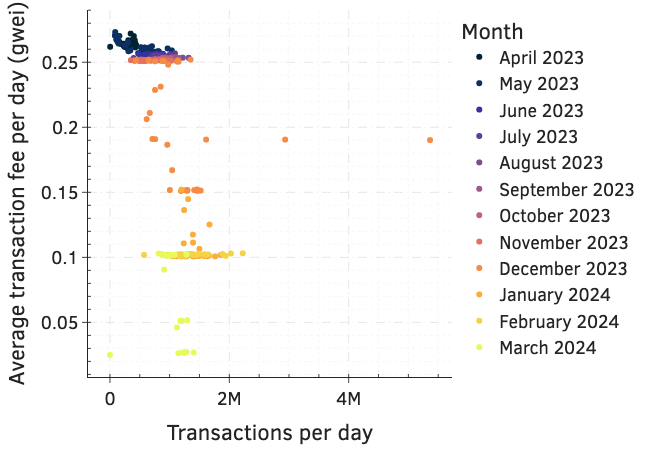

In [30]:
fig = px.scatter(
    tx_data_per_day_df, 
    x="tx_count", 
    y="avg_gas_price_tx_gwei", 
    color="Month",
    color_discrete_sequence=px.colors.sequential.thermal)

update_plotly_layout_in_place(fig=fig, width=650, height=height)

fig.update_layout(xaxis_title="Transactions per day",
                  yaxis_title="Average transaction fee per day (gwei)")

fig.write_image(os.path.join(plots_dir,'avg-tx-fee-vs-tx-count.pdf'))
fig.show('png')

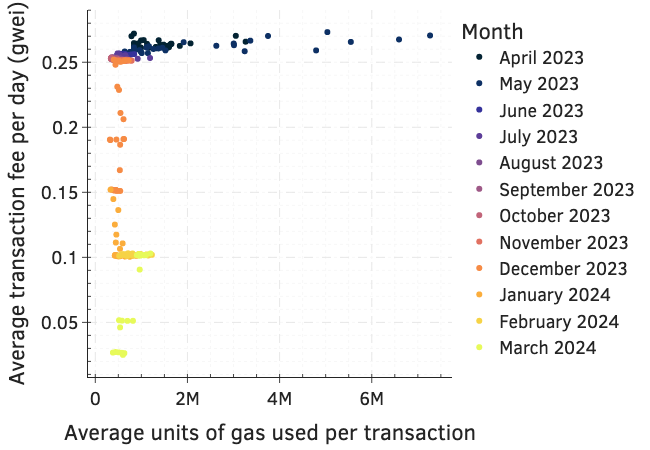

In [31]:
tx_data_per_day_df["Month"] = tx_data_per_day_df["day"].dt.month_name() + " " + tx_data_per_day_df["day"].dt.year.astype("str")

fig = px.scatter(
    tx_data_per_day_df, 
    x="avg_gas_used_tx", 
    y="avg_gas_price_tx_gwei", 
    color="Month",
    color_discrete_sequence=px.colors.sequential.thermal)

update_plotly_layout_in_place(fig=fig, width=650, height=height)

fig.update_layout(xaxis_title="Average units of gas used per transaction",
                  yaxis_title="Average transaction fee per day (gwei)")

fig.write_image(os.path.join(plots_dir,'avg-tx-fee-vs-avg-gas-usage.pdf'))
fig.show('png')